In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import gc
import os
import sklearn
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Parallel, delayed
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [3]:
%aimport data.delicious_t140
%aimport helpers.labels

In [4]:
from data.delicious_t140 import load_or_get_from_cache
from helpers.labels import truncate_labels

In [5]:
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/delicious-t140/")

DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140/"
TAGINFO=DATA_ROOT+"taginfo.xml"

In [6]:
docs_df = load_or_get_from_cache(TAGINFO,INTERIM_DATA_ROOT)

In [7]:
docs_df.describe(include=['number'])

,num_users,num_unique_tags
count,143713.000000,143713.000000
mean,182.588423,13.862100
std,663.499596,8.319592
min,2.000000,2.000000
25%,13.000000,6.000000
50%,35.000000,12.000000
75%,122.000000,24.000000
max,46215.000000,25.000000


## number of documents

In [8]:
len(docs_df)

143713

In [9]:
docs_df.head()

,filename,filetype,hash,unique_tags,url,num_users,num_unique_tags
0,66fa11b33b6ac183314892703c20fa47.html,html,66fa11b33b6ac183314892703c20fa47,"conventions,reference,python,style,guidelines,...",http://lists.osafoundation.org/pipermail/dev/2...,27,8
1,21899d001299ceadc852ed22e1b2b725.html,html,21899d001299ceadc852ed22e1b2b725,"assembly,tools,framework,technology,virtualiza...",http://llvm.org/,830,24
2,bd7c9734cd1a5c8a55328a1a9ce4d4d2.html,html,bd7c9734cd1a5c8a55328a1a9ce4d4d2,"operating,alternatives,ubuntu,download,compute...",http://linuxappfinder.com/alternatives,47,17
3,ff186471d34e1440845b80d61733f8ef.html,html,ff186471d34e1440845b80d61733f8ef,"gnome,notes,tomboy,software,wiki,linux",http://live.gnome.org/Tomboy,7,6
4,cc7afd7b1b9e0c29ba72978b5edd8ed5.html,html,cc7afd7b1b9e0c29ba72978b5edd8ed5,"web20,teaching,blogs",http://lisahistory.net/wordpress/,7,3


In [10]:
docs_df.describe(include=['number'])

,num_users,num_unique_tags
count,143713.000000,143713.000000
mean,182.588423,13.862100
std,663.499596,8.319592
min,2.000000,2.000000
25%,13.000000,6.000000
50%,35.000000,12.000000
75%,122.000000,24.000000
max,46215.000000,25.000000


In [11]:
docs_df.describe(include=['object'])

,filename,filetype,hash,unique_tags,url
count,143713,143713,143713,143713,143713
unique,143713,1,143713,142545,143713
top,658d3918dd2f9bc9e7e56e3d0b5ea43a.html,html,3b97c9fc00a76c804d91a86788d25773,"recipes,food,cooking",http://www.energyfederation.org/consumer/defau...
freq,1,143713,1,37,1


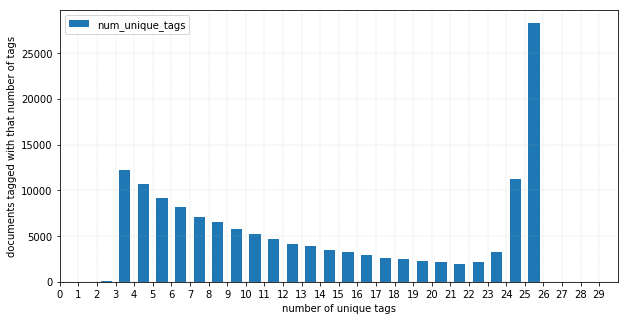

In [96]:
docs_df[['num_unique_tags']].plot(kind='hist',bins=np.arange(1.0,30,1),rwidth=0.6)

plt.gcf().set_size_inches(10,5)
# plt.gca().set_title('Number of unique tags per document',fontsize=20)
plt.xlabel('number of unique tags',fontsize=10)
plt.ylabel('documents tagged with that number of tags', fontsize=10)
plt.gca().set_xlim(0,30)

plt.gca().grid(True)
gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()

for line in gridlines:
    line.set_linestyle('--')
    line.set_linewidth(0.2)
    
plt.xticks(np.arange(0, 30, 1))
plt.show()

## number of unique tags

In [17]:
tagsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

flat_list = []

for tagset in tagsets:
    for tag in tagset:
        flat_list.append(tag)
        
flat_set = set(flat_list)

In [18]:
len(flat_set)

62989

## number of times each tag was given to a movie
(not counting multiple assignments)

In [ ]:
# must sample the dataset or we can't chart it




In [19]:
labelsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

In [ ]:
# truncate some otherwise we can't chart it
MIN_TAG_DF = 50
truncated_labels = truncate_labels(labelsets,MIN_TAG_DF)

In [20]:
tag_assignments = MultiLabelBinarizer(sparse_output=True).fit_transform(labelsets)

In [30]:
number_of_tags_per_resource = tag_assignments.sum(axis=1)

In [33]:
number_of_tags_per_resource.mean()

13.8621001579537

In [34]:
number_of_tags_per_resource.min()

2

In [35]:
number_of_tags_per_resource.max()

25

In [61]:
df = pd.DataFrame.from_records(np.array(number_of_tags_per_resource),columns=['tag_count'])
df.head()

,tag_count
0,8
1,24
2,17
3,6
4,3


In [71]:
df['tag_count'].value_counts(sort=False).to_frame().to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  tag\\_count \\\\\n\\midrule\n2  &         50 \\\\\n3  &      12249 \\\\\n4  &      10687 \\\\\n5  &       9102 \\\\\n6  &       8144 \\\\\n7  &       7133 \\\\\n8  &       6559 \\\\\n9  &       5786 \\\\\n10 &       5248 \\\\\n11 &       4694 \\\\\n12 &       4172 \\\\\n13 &       3864 \\\\\n14 &       3454 \\\\\n15 &       3211 \\\\\n16 &       2900 \\\\\n17 &       2641 \\\\\n18 &       2521 \\\\\n19 &       2242 \\\\\n20 &       2139 \\\\\n21 &       1991 \\\\\n22 &       2155 \\\\\n23 &       3272 \\\\\n24 &      11218 \\\\\n25 &      28281 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
number_of_resources_per_tag = tag_assignments.sum(axis=0)

KeyboardInterrupt: 

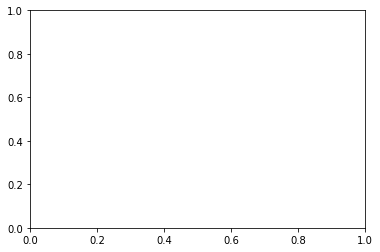

In [72]:
plt.hist(tag_sums,bins=np.arange(1.0,50,1),rwidth=0.5)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of documents per tag',fontsize=30)
plt.gca().set_xlim(0,50)
plt.xlabel('number of unique tags per document',fontsize=20)
plt.ylabel('number of documents', fontsize=20)
plt.xticks(np.arange(0, 100, 1))
plt.text(20,300,r'$\mu={0:.2f},\ \sigma={1:.2f}$'.format(tag_sums.mean(), tag_sums.std()), fontsize=20)

In [ ]:
docs_df[['num_users']].plot(kind='hist',bins=np.arange(1.0,150,1),rwidth=0.8)
plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of documents having that number of different users tag it',fontsize=30)
plt.gca().set_xlim(1,150)

In [ ]:
tagsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

flat_list = []

for tagset in tagsets:
    for tag in tagset:
        flat_list.append(tag)
        
flat_set = set(flat_list)

## number of unique tags

In [ ]:
len(flat_set)

## number of times each tag was given to a document

(not counting multiple assignments)

In [ ]:
labelsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

In [ ]:
tag_counts = MultiLabelBinarizer(sparse_output=True).fit_transform(labelsets).sum(axis=0)

In [ ]:
tag_counts = tag_counts.astype('uint8')
tag_counts = np.array(tag_counts).ravel()

In [ ]:
plt.hist(,bins=np.arange(1.0,100,1),rwidth=0.9)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('tag counts by use frequency',fontsize=30)
plt.gca().set_xlim(1,100)
plt.xlabel('times used',fontsize=20)
plt.ylabel('number of tags', fontsize=20)
plt.text(20,6000,r'$\mu={0:.2f},\ \sigma={1:.2f}$'.format(tag_counts.mean(), tag_counts.std()), fontsize=20)